<a href="https://colab.research.google.com/github/2403A51L47/AIML_2025/blob/main/regression_clustering_feature_importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split as tts
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding, MDS
from sklearn.decomposition import KernelPCA, FactorAnalysis, FastICA, NMF, PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

In [3]:
tips = pd.read_csv("tips.csv")
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


In [4]:
tips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  244 non-null    float64
 1   tip         244 non-null    float64
 2   sex         244 non-null    object 
 3   smoker      244 non-null    object 
 4   day         244 non-null    object 
 5   time        244 non-null    object 
 6   size        244 non-null    int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 13.5+ KB


In [5]:
tips.dropna(inplace=True)

In [6]:
categorical_cols = tips.select_dtypes(exclude=['number']).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    tips[col] = le.fit_transform(tips[col])
    label_encoders[col] = le
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,0,0,2,0,2
1,10.34,1.66,1,0,2,0,3
2,21.01,3.50,1,0,2,0,3
3,23.68,3.31,1,0,2,0,2
4,24.59,3.61,0,0,2,0,4
...,...,...,...,...,...,...,...
239,29.03,5.92,1,0,1,0,3
240,27.18,2.00,0,1,1,0,2
241,22.67,2.00,1,1,1,0,2
242,17.82,1.75,1,0,1,0,2


In [7]:
X = tips.drop(columns=["tip"])
Y = tips['tip']

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# *Regressions*



In [9]:
X_train, X_test,Y_train, Y_test = tts(X, Y, test_size=0.2, random_state=42)

models = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Support Vector Regressor': SVR(),
    'K-Nearest Neighbors': KNeighborsRegressor()
}

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

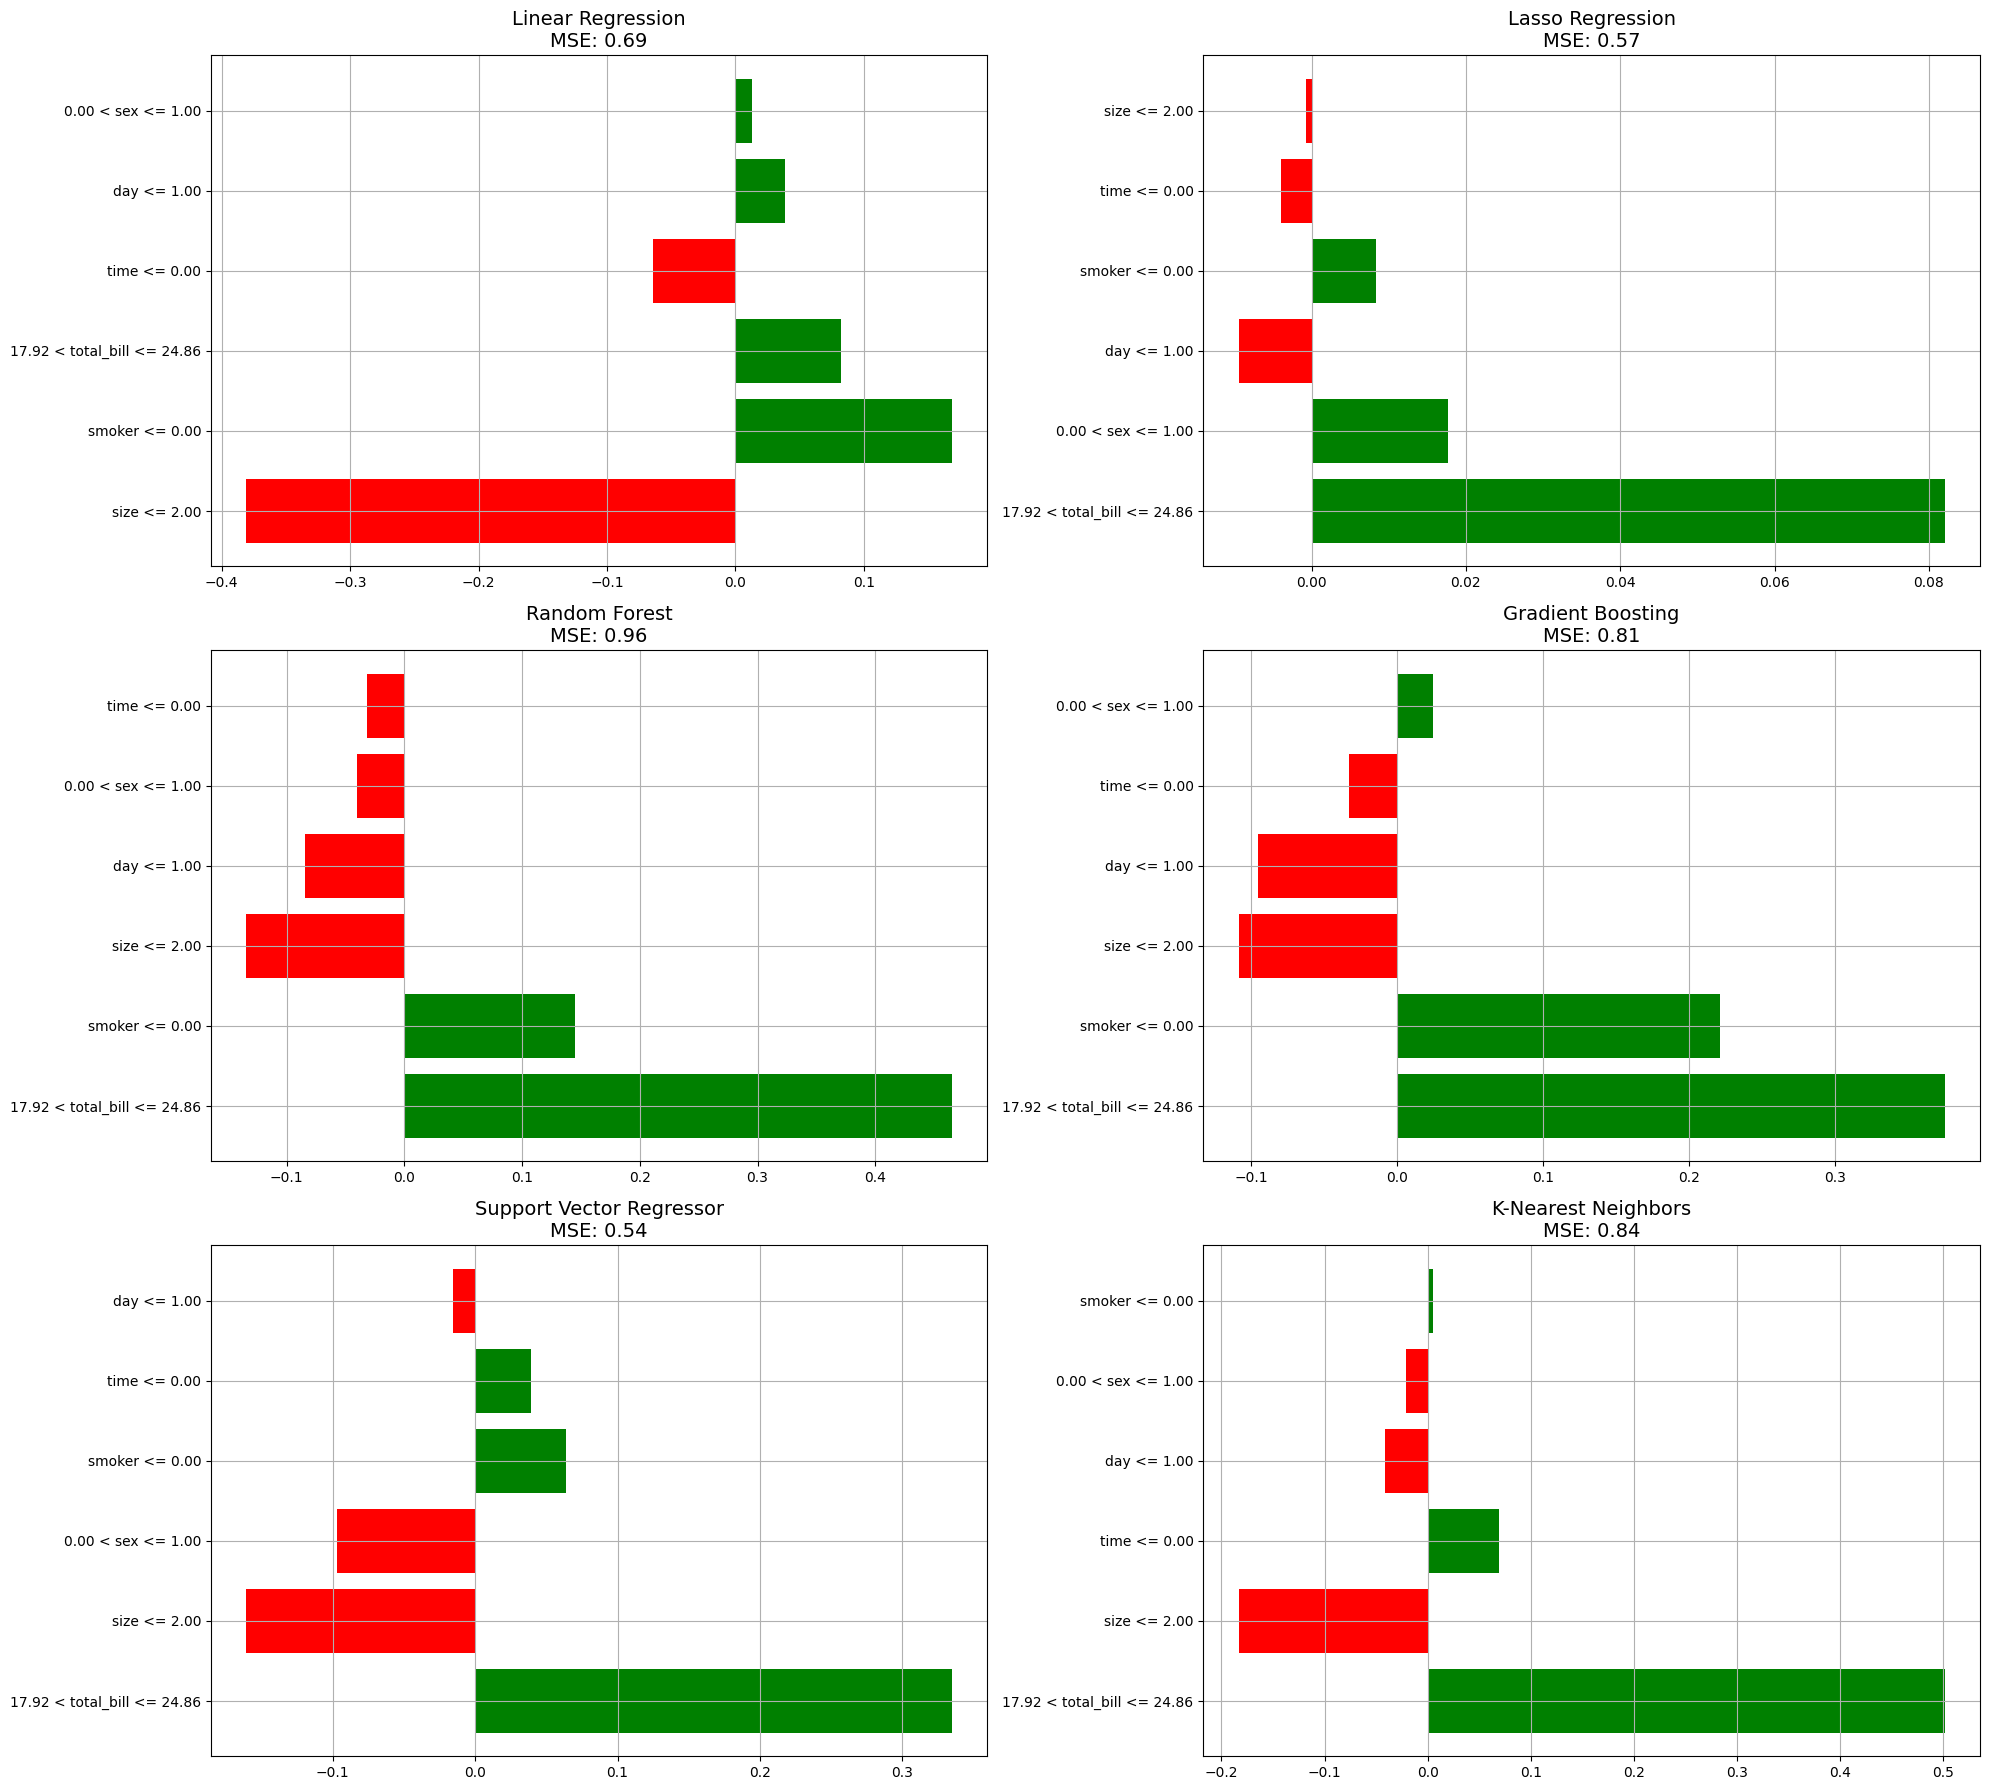

In [10]:
explainer = LimeTabularExplainer(X_train.values,
                                 feature_names=X_train.columns.tolist(),
                                 class_names=['tip'],
                                 discretize_continuous=True,
                                 mode='regression')

num_models = len(models)
cols = 2
rows = (num_models + 1) // cols

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10 * cols, 6 * rows))

axes = axes.flatten() if num_models > 1 else [axes]

for ax, (name, model) in zip(axes, models.items()):
    model.fit(X_train, Y_train)
    pred = model.predict(X_test)
    mse = mean_squared_error(Y_test, pred)

    exp = explainer.explain_instance(X_test.values[0],
                                     model.predict,
                                     num_features=len(X_train.columns))
    exp_list = exp.as_list()

    colors = ['green' if x[1] > 0 else 'red' for x in exp_list]

    ax.barh([x[0] for x in exp_list], [x[1] for x in exp_list], color=colors)
    ax.set_title(f"{name}\nMSE: {mse:.2f}", fontsize=14)
    ax.tick_params(axis='y', labelsize=10)
    ax.tick_params(axis='x', labelsize=10)
    ax.grid(True)

for j in range(len(models), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

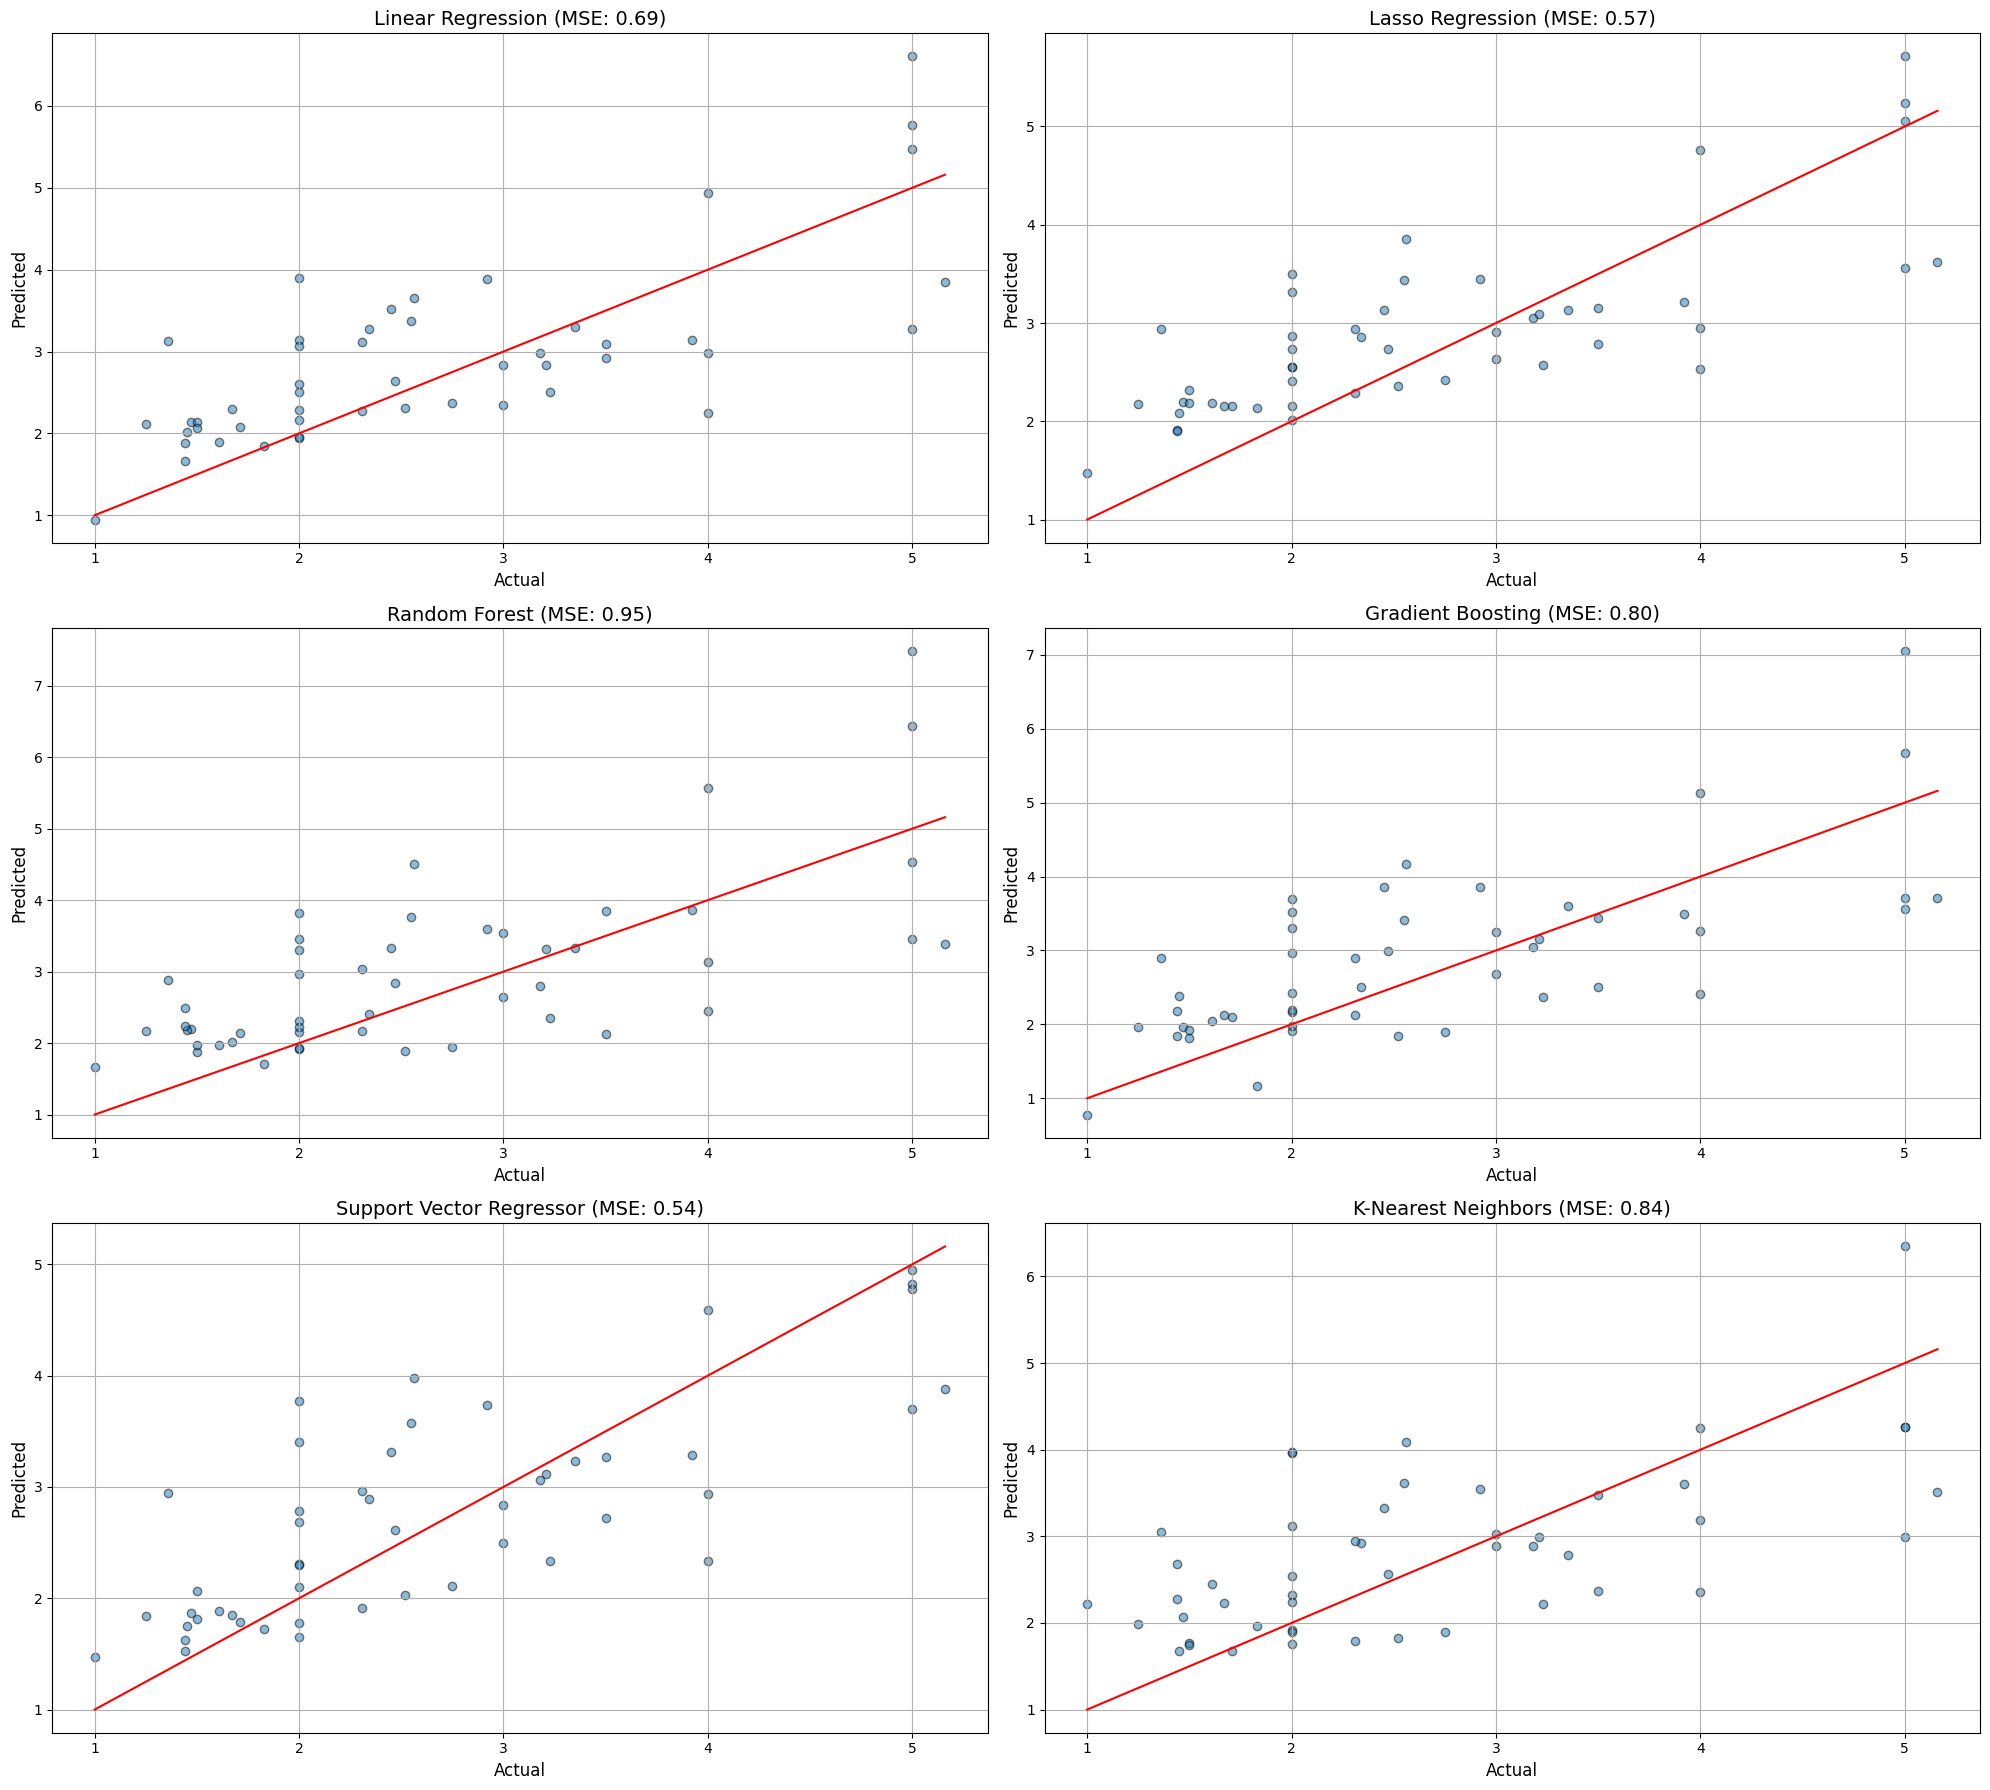

In [11]:
num_models = len(models)
cols = 2
rows = (num_models + 1) // cols

plt.figure(figsize=(10 * cols, 6 * rows))

mse_scores = {}

for i, (name, model) in enumerate(models.items(), 1):
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    mse = mean_squared_error(Y_test, Y_pred)
    mse_scores[name] = mse

    plt.subplot(rows, cols, i)
    plt.scatter(Y_test, Y_pred, alpha=0.5, edgecolor='k')
    plt.plot([Y_test.min(),Y_test.max()],[Y_test.min(),Y_test.max()],color='r')
    plt.xlabel("Actual", fontsize=12)
    plt.ylabel("Predicted", fontsize=12)
    plt.title(f"{name} (MSE: {mse:.2f})", fontsize=14)
    plt.grid(True)

plt.tight_layout()
plt.show()

# *Clustering*

In [12]:
def plot_clustering(X, Y, feature_name=None):
    clustering_algorithms = {
        "KMeans": KMeans(n_clusters=3, random_state=42),
        "Agglomerative": AgglomerativeClustering(n_clusters=3),
        "DBSCAN": DBSCAN(eps=0.5, min_samples=5),
        "Spectral": SpectralClustering(n_clusters=3, random_state=42),
        "GaussianMixture": GaussianMixture(n_components=3, random_state=42)
    }

    if feature_name:
        if feature_name in X.columns:
            features = [feature_name]
        else:
            print(f"Feature '{feature_name}' not found in dataset")
            features = X.columns
    else:
        features = X.columns

    plt.figure(figsize=(15, 10))
    for i, (name, model) in enumerate(clustering_algorithms.items()):
        try:
            clusters = model.fit_predict(X)
            plt.subplot(2, 3, i + 1)
            if len(features) == 1:
              plt.scatter(X[features[0]],Y,c=clusters,cmap='viridis',alpha=0.6)
              plt.xlabel(features[0])
            else:
              plt.scatter(X.iloc[:, 0],Y,c=clusters, cmap='viridis', alpha=0.6)
              plt.xlabel(X.columns[0])
            plt.ylabel("Tip Amount")
            plt.title(f"{name} Clustering")
        except Exception as e:
            print(f"Error in {name}: {e}")
    plt.tight_layout()
    plt.show()

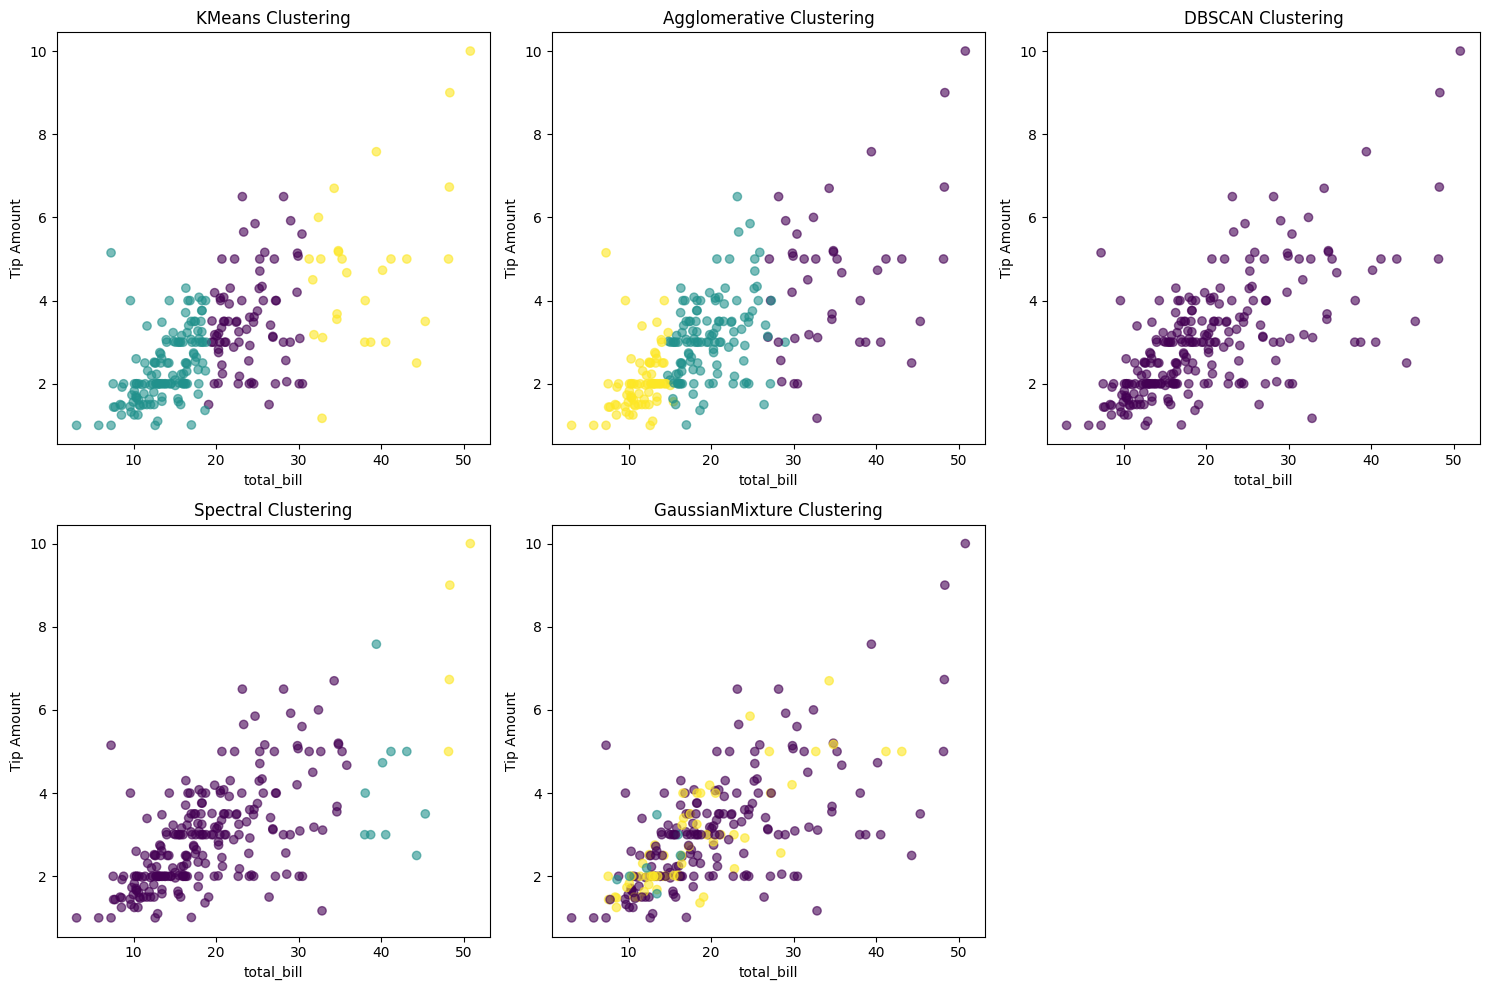

In [13]:
plot_clustering(X, Y, feature_name="total_bill")

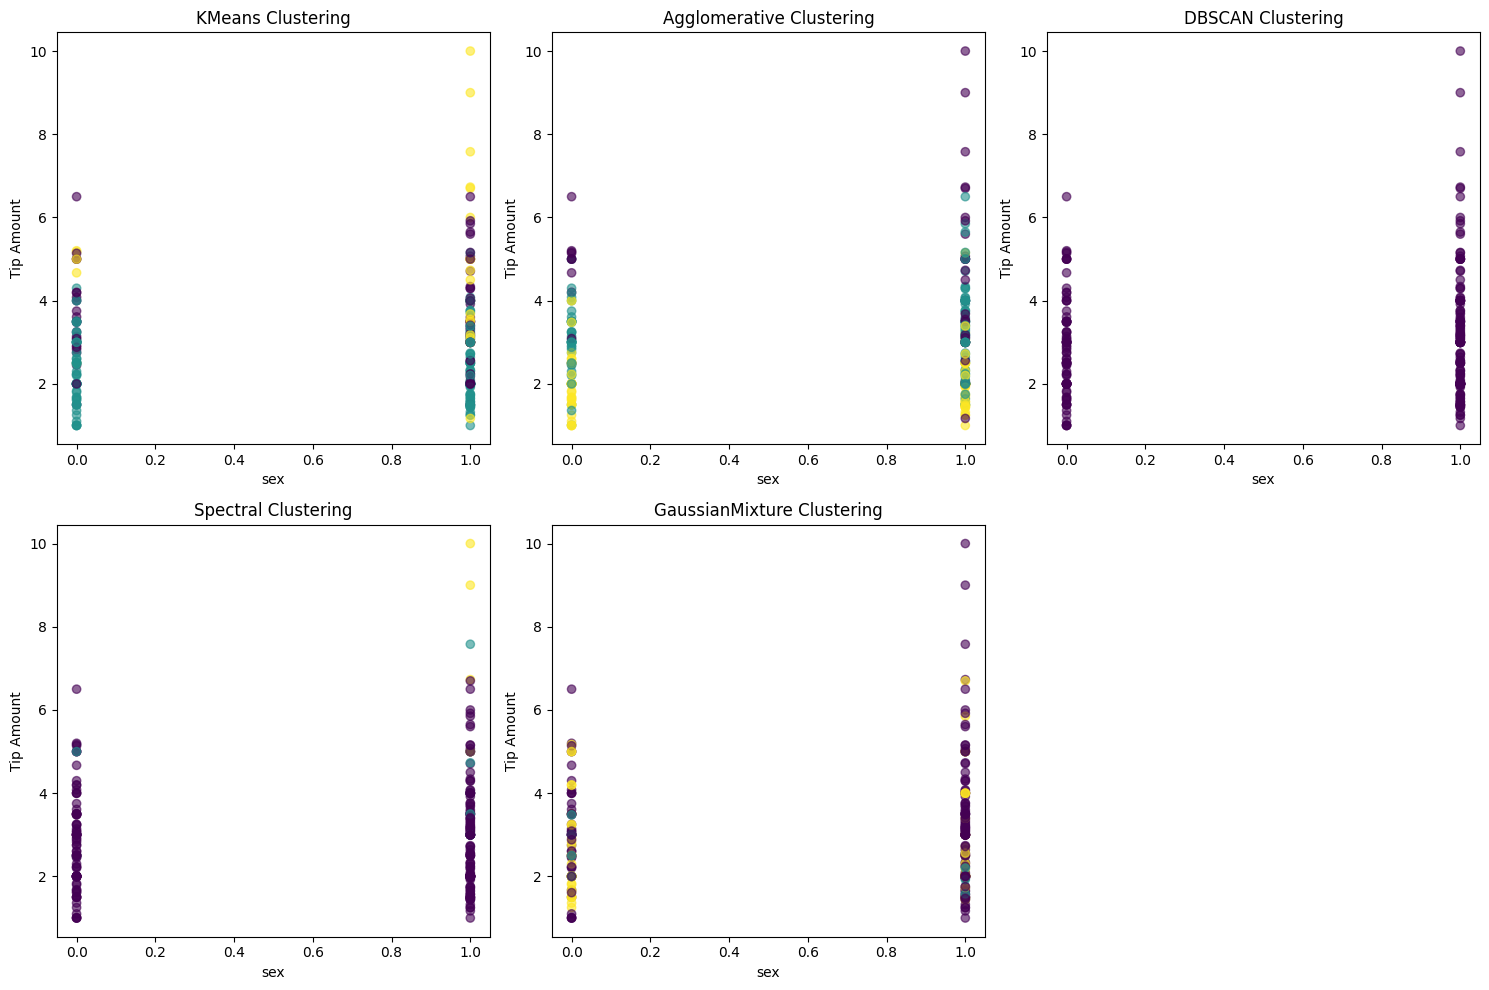

In [14]:
plot_clustering(X, Y, feature_name="sex")

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


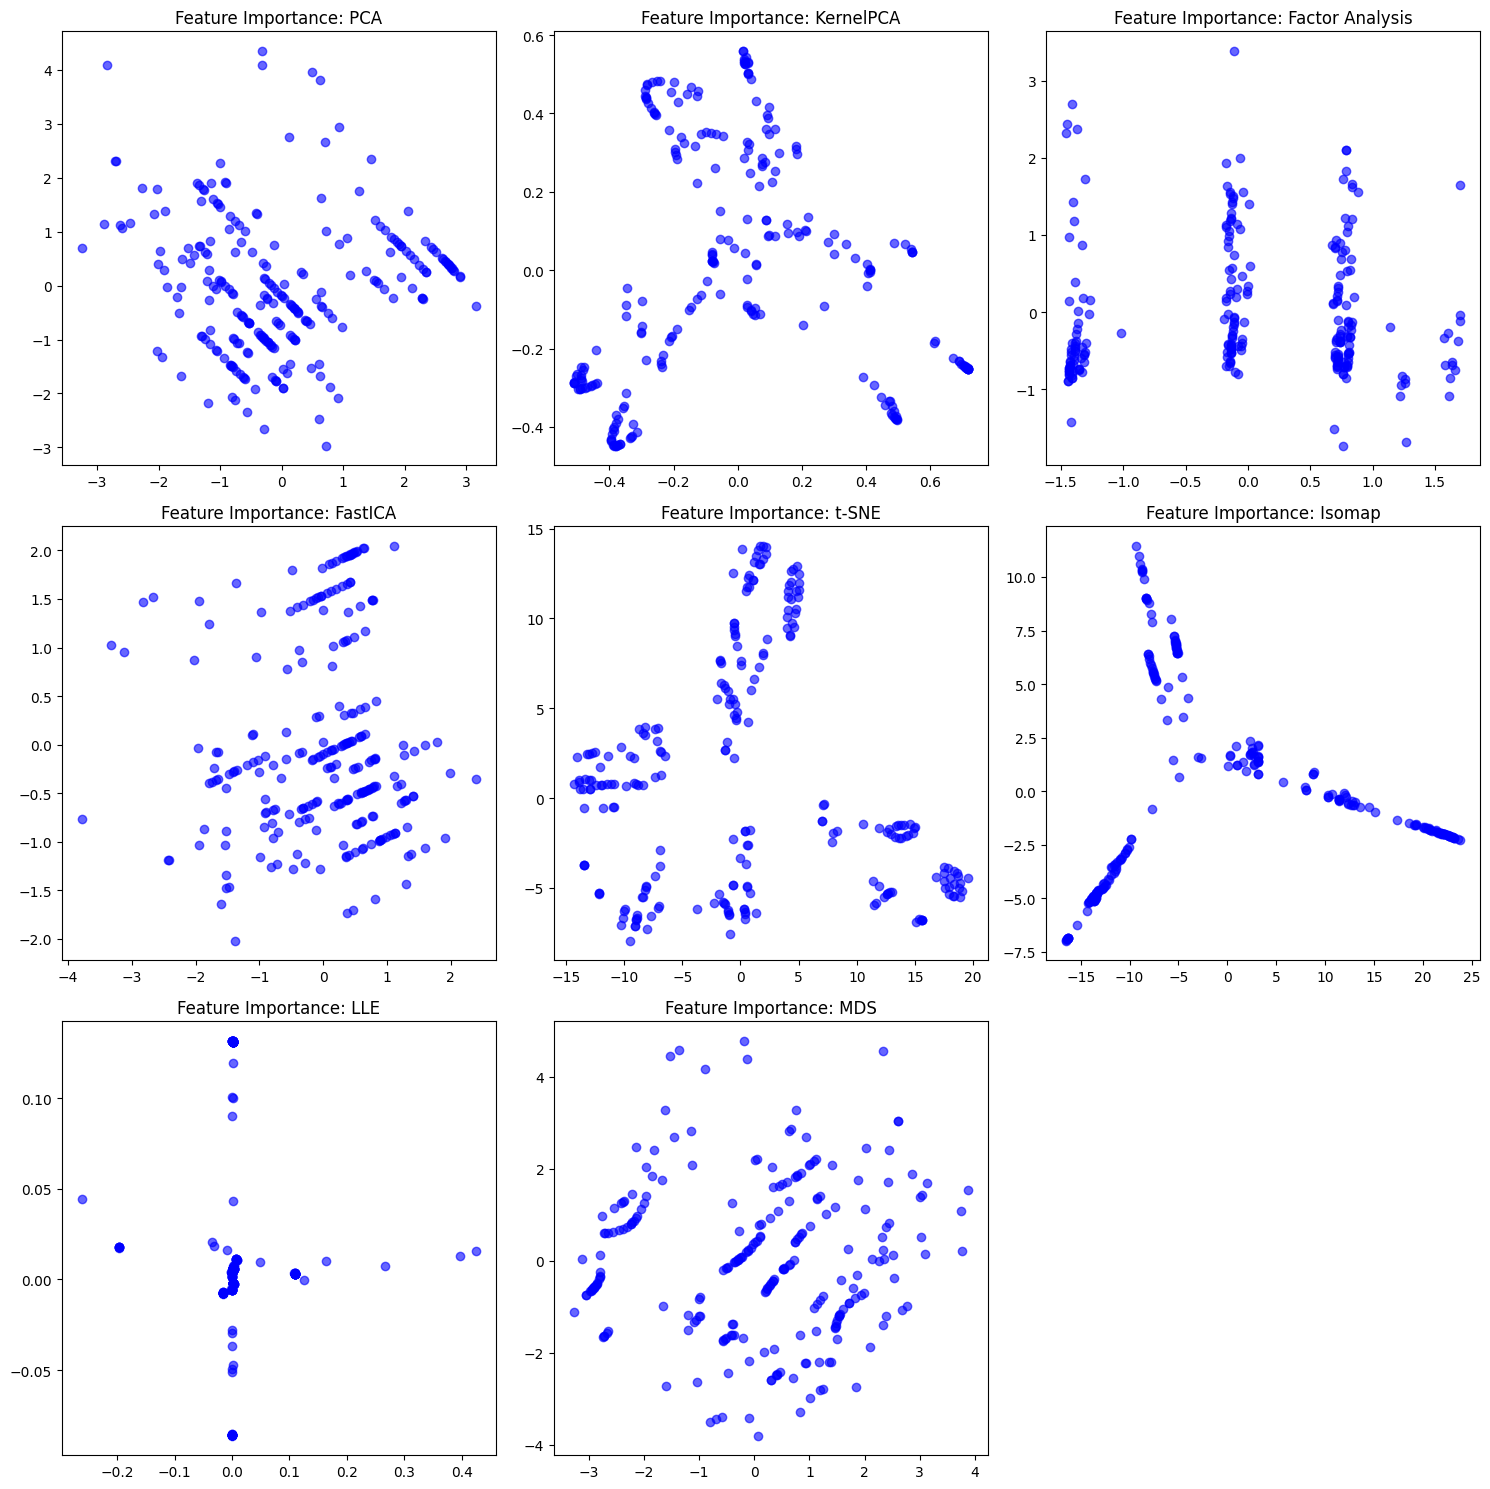

In [15]:
dim_reduction_methods = {
    "PCA": PCA(n_components=2),
    "KernelPCA": KernelPCA(n_components=2, kernel='rbf'),
    "Factor Analysis": FactorAnalysis(n_components=2),
    "FastICA": FastICA(n_components=2),
    "t-SNE": TSNE(n_components=2, random_state=42),
    "Isomap": Isomap(n_components=2),
    "LLE": LocallyLinearEmbedding(n_components=2),
    "MDS": MDS(n_components=2),
}

plt.figure(figsize=(15, 15))
for i, (name, model) in enumerate(dim_reduction_methods.items(), 1):
    X_reduced = model.fit_transform(X_scaled)
    plt.subplot(3, 3, i)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], alpha=0.6, color='blue')
    plt.title(f"Feature Importance: {name}")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:736: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  pl.xlim((slow, shigh))
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:756: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  pl.xlim((slow, shigh))


<Figure size 640x480 with 0 Axes>

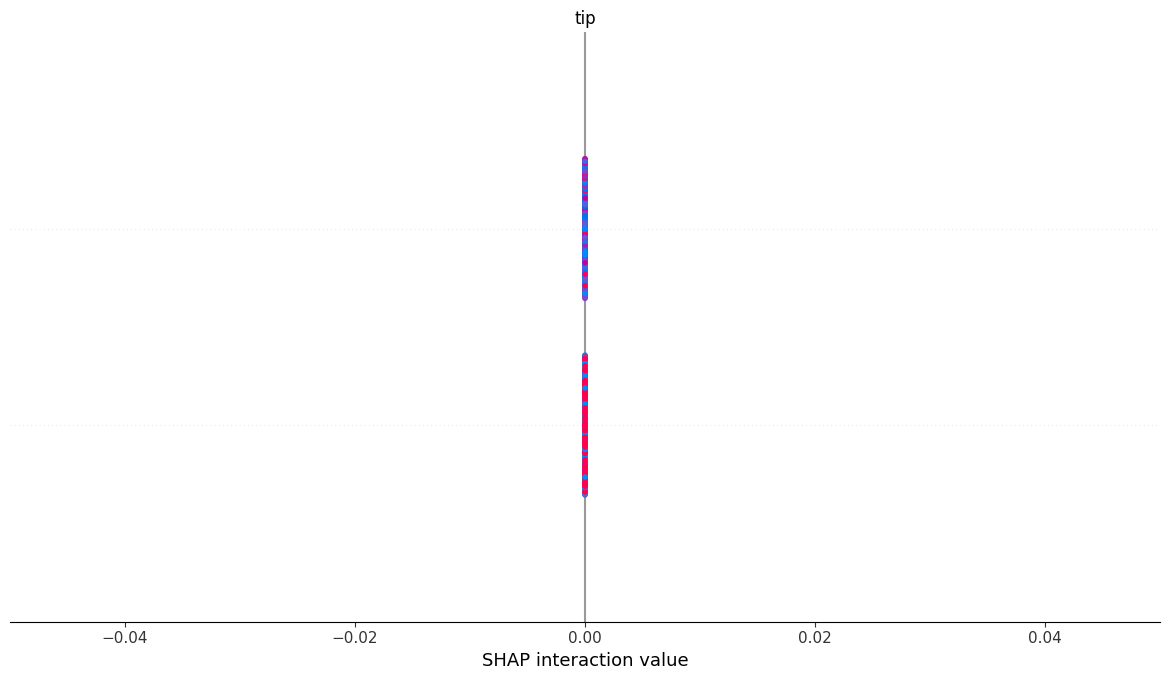

In [16]:
explainer = shap.Explainer(lambda x: np.zeros((x.shape[0],2)), X)
shap_values = explainer(X)
shap.summary_plot(shap_values, X, feature_names=tips.columns[:-1])